## Basic Setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import networkx as nx


from platform import python_version
print("Python Version", python_version())
print('PyTorch Version', torch.__version__)

Python Version 3.7.12
PyTorch Version 1.10.0+cu111


In [ ]:
# Device
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = "cuda"
print("device =", DEVICE)
# Reproducibility
SEED = 3407
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# Parallel processing
NUM_CORES = 20
torch.set_num_threads(NUM_CORES)

device = cpu


In [ ]:
if DEVICE=="cpu":
    !pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cpu.html
else:
    !pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
import torch_geometric as pyg
print('PyTorch Geometric Version', pyg.__version__)

     |████████████████████████████████| 291 kB 34.8 MB/s 
     |████████████████████████████████| 639 kB 39.6 MB/s 
     |████████████████████████████████| 328 kB 44.0 MB/s 
     |████████████████████████████████| 138 kB 57.4 MB/s 
     |████████████████████████████████| 325 kB 30.1 MB/s 
     |████████████████████████████████| 407 kB 51.0 MB/s 
     |████████████████████████████████| 45 kB 3.5 MB/s 
PyTorch Geometric Version 2.0.2


## Prepare graph

In [ ]:
def to_node_idx(x,y):
    return (8*x) + y

def to_coord(node_idx):
    return node_idx//8, node_idx%8

edge_index = [[],[]]
for i in range(8):
    for j in range(8):
        if i<7:
            edge_index[0].append(to_node_idx(i,j));    edge_index[1].append(to_node_idx(i+1,j))
            edge_index[0].append(to_node_idx(i+1,j));    edge_index[1].append(to_node_idx(i,j))
        if i>0:
            edge_index[0].append(to_node_idx(i,j));    edge_index[1].append(to_node_idx(i-1,j))
            edge_index[0].append(to_node_idx(i-1,j));    edge_index[1].append(to_node_idx(i,j))
        if j<7:
            edge_index[0].append(to_node_idx(i,j));    edge_index[1].append(to_node_idx(i,j+1))
            edge_index[0].append(to_node_idx(i,j+1));    edge_index[1].append(to_node_idx(i,j))
        if j>0:
            edge_index[0].append(to_node_idx(i,j));    edge_index[1].append(to_node_idx(i,j-1))
            edge_index[0].append(to_node_idx(i,j-1));    edge_index[1].append(to_node_idx(i,j))

edge_index = torch.tensor(edge_index, dtype=torch.long).to(DEVICE)
COINS = set([10, 30, 50])

In [ ]:
data = pyg.data.Data(edge_index = edge_index).to(DEVICE)
NUM_NODES = data.num_nodes
NUM_EDGES = data.num_edges
print("No. of nodes =", NUM_NODES)
print("No. of edges =", NUM_EDGES)
print("edge_index.shape =", data.edge_index.shape)

No. of nodes = 64
No. of edges = 448
edge_index.shape = torch.Size([2, 448])


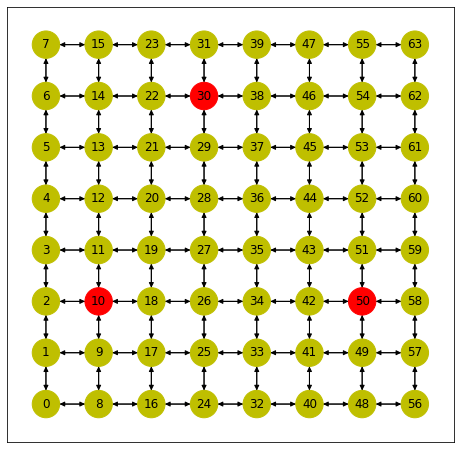

In [ ]:
graph = pyg.utils.to_networkx(data)
pos = {}
for idx in range(64):
    x,y = to_coord(idx)
    pos[idx] = np.array([x,y])

fig, ax = plt.subplots(figsize=(8, 8))
color = ['y' for i in range(64)]
for coin in COINS:
    color[coin] = 'r'
nx.drawing.nx_pylab.draw_networkx(graph, node_color=color, pos=pos, node_size=750, ax=ax)

In [ ]:
def plot_policy(policy):
    u = [[0.75 for i in range(8)] for j in range(8)]
    v = [[0.75 for i in range(8)] for j in range(8)]
    for state in range(64):
        x,y = to_coord(state)
        action = np.argmax(policy[state])
        if action==0:
            u[y][x] = 0
            v[y][x] = 0.75
        elif action==1:
            u[y][x] = 0.75
            v[y][x] = 0
        elif action==2:
            u[y][x] = 0
            v[y][x] = -0.75
        else:
            u[y][x] = -0.75
            v[y][x] = 0

    graph = pyg.utils.to_networkx(data)
    pos = {}
    for idx in range(64):
        x,y = to_coord(idx)
        pos[idx] = np.array([x,y])

    fig, ax = plt.subplots(figsize=(8, 8))
    color = ['y' for i in range(64)]
    for coin in COINS:
        color[coin] = 'r'
    nx.drawing.nx_pylab.draw_networkx(graph, node_color=color, pos=pos, node_size=750, ax=ax, edgelist=[])
    
    X = np.arange(0,8,1)
    Y = np.arange(0,8,1)

    ax.quiver(X, Y, u, v, scale_units='xy', scale=1)
    
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.set_aspect('equal')
    plt.grid()
    plt.show()

## 3. Define random walker and Initialize policy

In [ ]:
POLICY = {}
for i in range(8):
    for j in range(8):
        u = to_node_idx(i,j)
        POLICY[u] = np.array([0.0, 0.0, 0.0, 0.0])
        if j<7: # up
            POLICY[u][0] = 1.0
        if i<7: # right
            POLICY[u][1] = 1.0
        if j>0: # down
            POLICY[u][2] = 1.0
        if i>0: # left
            POLICY[u][3] = 1.0
        POLICY[u] /= sum(POLICY[u])

Q = {}
for i in range(8):
    for j in range(8):
        u = to_node_idx(i,j)
        Q[u] = {}
        if j<7: # up
            Q[u][0] = torch.rand(1)
        if i<7: # right
            Q[u][1] = torch.rand(1)
        if j>0: # down
            Q[u][2] = torch.rand(1)
        if i>0: # left
            Q[u][3] = torch.rand(1)

RET = {}
for i in range(8):
    for j in range(8):
        u = to_node_idx(i,j)
        RET[u] = [[], [], [], []]

In [ ]:
def sample_episode(walk_len, start_node=None):
    if start_node==None:
        start_node = np.random.randint(0,NUM_NODES)
    states = []
    actions = []
    rewards = []
    curr_state = start_node
    while len(states) < walk_len:
        states.append(curr_state)
        if curr_state in COINS:
            rewards.append(1.0)
        else:
            rewards.append(0.0)
        
        actions.append(np.random.choice(a=[0,1,2,3], size=None, replace=True, p=POLICY[curr_state]))
        if actions[-1]==0:      # up
            curr_state = to_node_idx(to_coord(curr_state)[0], to_coord(curr_state)[1]+1)
        elif actions[-1]==1:    # right
            curr_state = to_node_idx(to_coord(curr_state)[0]+1, to_coord(curr_state)[1])
        elif actions[-1]==2:    # down
            curr_state = to_node_idx(to_coord(curr_state)[0], to_coord(curr_state)[1]-1)
        else:                   # left
            curr_state = to_node_idx(to_coord(curr_state)[0]-1, to_coord(curr_state)[1])
    return states, actions, rewards

## Build models

In [ ]:
# Set Hyperparameters
EMBED_DIM = 512
EPS = 1e-15
INIT_LR1 = 0.1

WALK_LEN = 128
INIT_LR2 = 1e-2

In [ ]:
class Node2Vec(torch.nn.Module):
    def __init__(self, embedding_dim=EMBED_DIM, num_nodes=NUM_NODES, sparse=False):
        super(Node2Vec, self).__init__()
        self.embedding_dim = embedding_dim
        self.embedding = torch.nn.Embedding(num_nodes, embedding_dim, sparse=sparse)
        self.reset_parameters()


    def reset_parameters(self):
        self.embedding.reset_parameters()


    def forward(self, batch=None):
        emb = self.embedding.weight
        return emb if batch is None else emb[batch]


    def loss(self, pos_rw, neg_rw):
        start, rest = pos_rw[:, 0], pos_rw[:, 1:].contiguous()
        h_start = self.embedding(start).view(pos_rw.size(0), 1, self.embedding_dim)
        h_rest = self.embedding(rest.view(-1)).view(pos_rw.size(0), -1, self.embedding_dim)
        out = (h_start * h_rest).sum(dim=-1).view(-1)
        pos_loss = -torch.log(torch.sigmoid(out) + EPS).mean()

        start, rest = neg_rw[:, 0], neg_rw[:, 1:].contiguous()
        h_start = self.embedding(start).view(neg_rw.size(0), 1, self.embedding_dim)
        h_rest = self.embedding(rest.view(-1)).view(neg_rw.size(0), -1, self.embedding_dim)
        out = (h_start * h_rest).sum(dim=-1).view(-1)
        neg_loss = -torch.log(1 - torch.sigmoid(out) + EPS).mean()
    
        return pos_loss + neg_loss

model1 = Node2Vec().to(DEVICE)
optimizer1 = torch.optim.Adam(model1.parameters(), INIT_LR1)
platLR1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, mode='min', factor=0.5, patience=1, threshold=0.0001, 
                                                    threshold_mode='abs', cooldown=0, min_lr=0, eps=1e-10, verbose=False)

In [ ]:
def get_contexts(walks, size):
    batch = torch.tensor([], dtype=torch.int, requires_grad=False).to(DEVICE)
    for sequence in walks:
        for i in range(0,len(sequence)-size):
            batch = torch.cat((batch, sequence[i:i+size].reshape(1,size)), axis=0)
    return batch

In [ ]:
class InferNet(torch.nn.Module):
    def __init__ (self, input_len=EMBED_DIM):
        super(InferNet, self).__init__()
        self.input_size = input_len
        self.lin1 = torch.nn.Linear(self.input_size,512)
        self.lin4 = torch.nn.Linear(512,1)

    def forward(self, X):
        X = torch.tanh(self.lin1(X))
        X = self.lin4(X)
        return X

model2 = InferNet().to(DEVICE)
optimizer2 = torch.optim.Adam(model2.parameters(), INIT_LR2)
platLR2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='min', factor=0.5, patience=5, threshold=1e-5, 
                                                    threshold_mode='abs', cooldown=0, min_lr=0, eps=1e-10, verbose=False)

In [ ]:
mse = torch.nn.MSELoss(reduction='sum')
def getLoss2(imm_rewards, rewards):
    main_loss = mse(torch.sum(imm_rewards), torch.sum(rewards)) / WALK_LEN
    return main_loss

In [ ]:
def printRewards(rewards):
    matrix = np.array([[float(rewards[to_node_idx(i,j)][0]) for i in range(8)] for j in range(8)])
    cm = sns.light_palette("blue", as_cmap=True)
    x=pd.DataFrame(matrix).iloc[::-1]
    x=x.style.background_gradient(cmap=cm, axis=None)
    display(x)

## Train models

In [ ]:
NUM_ITER = 300
CONT_SIZE = 3
NUM_NEG = 1
losses1 = []
losses2 = []
# GAMMA = 0.5

model2.eval()
all_states = model1.forward(torch.tensor([i for i in range(NUM_NODES)])).reshape(NUM_NODES,EMBED_DIM)
imm_rewards = model2.forward(all_states).reshape(NUM_NODES,1)
printRewards(imm_rewards)

for iter in range(1,NUM_ITER+1):
    states, actions, rewards = [], [], []
    for start in range(NUM_NODES):
        s, a, r = sample_episode(WALK_LEN, start)
        states.append(s)
        actions.append(a)
        rewards.append(r)
    neg_samples = torch.randint(low=0, high=NUM_NODES, size=(NUM_NODES,(WALK_LEN*NUM_NEG)-1))
    neg_samples = neg_samples.reshape(NUM_NODES, (WALK_LEN*NUM_NEG)-1)

    states = torch.tensor(states).to(DEVICE)
    actions = torch.tensor(actions).to(DEVICE)
    rewards = torch.tensor(rewards).to(DEVICE)
    neg_samples = torch.cat((states[:,0].reshape(NUM_NODES,1), neg_samples.to(DEVICE)), axis=1)

    model1.train()
    optimizer1.zero_grad()
    pos = get_contexts(states, CONT_SIZE)
    neg = get_contexts(neg_samples, CONT_SIZE)
    loss1 = model1.loss(pos.to(DEVICE), neg.to(DEVICE))
    loss1.backward()
    optimizer1.step()
    loss1 = float(loss1)
    platLR1.step(loss1)
    
    model2.train()
    loss2 = 0.0
    for i in range(NUM_NODES):
        optimizer2.zero_grad()
        ep_states = model1.forward(states[i,:].reshape(WALK_LEN)).reshape(WALK_LEN,EMBED_DIM)
        imm_rewards = model2.forward(ep_states).reshape(WALK_LEN,1)
        L = getLoss2(imm_rewards, rewards[i].reshape(WALK_LEN,1))
        L.backward()
        optimizer2.step()
        loss2 += float(L)
    loss2 /= float(NUM_NODES)
    platLR2.step(loss2)

    # if len(losses1)>0:
    #     loss1 = (GAMMA*loss1) + ((1-GAMMA)*losses1[-1])
    # if len(losses2)>0:
    #     loss2 = (GAMMA*loss2) + ((1-GAMMA)*losses2[-1])

    print("iter : "+str(iter)+" |  loss1 : "+str(np.around(loss1,6))+" |  loss2 : "+str(np.around(loss2,6)))
    losses1.append(loss1)
    losses2.append(loss2)

    if iter in [10, 50, 150, 300]:
        model2.eval()
        all_states = model1.forward(torch.tensor([i for i in range(NUM_NODES)])).reshape(NUM_NODES,EMBED_DIM)
        imm_rewards = model2.forward(all_states).reshape(NUM_NODES,1)
        printRewards(imm_rewards)

,0,1,2,3,4,5,6,7
7,-0.096312,-0.052164,-0.184436,-0.042942,0.181065,-0.219515,0.109105,0.447374
6,-0.286214,-0.258522,0.076433,0.412653,0.138243,-0.810946,0.302585,0.075944
5,-0.269227,0.007240,-0.231572,0.403893,-0.066074,-0.009555,-0.278564,0.350786
4,0.367310,0.407358,-0.123323,-0.238423,-0.136397,0.134321,0.319811,-0.014502
3,0.110826,0.155772,-0.073064,0.769978,0.033892,0.320755,0.226202,-0.199564
2,0.114600,-0.193299,-0.078518,-0.069977,-0.132767,0.170152,-0.052116,-0.596430
1,-0.014354,-0.128355,-0.262778,0.079164,-0.305579,-0.148568,0.325136,-0.569716
0,0.130310,-0.110663,0.048013,-0.363037,-0.104800,-0.144950,0.050885,-0.215876


iter : 1 |  loss1 : 18.202168 |  loss2 : 51.455153
iter : 2 |  loss1 : 13.48706 |  loss2 : 3.560434
iter : 3 |  loss1 : 12.355205 |  loss2 : 2.405142
iter : 4 |  loss1 : 11.641489 |  loss2 : 2.885881
iter : 5 |  loss1 : 11.203625 |  loss2 : 90.784861
iter : 6 |  loss1 : 11.188174 |  loss2 : 49.526362
iter : 7 |  loss1 : 10.942301 |  loss2 : 30.159016
iter : 8 |  loss1 : 10.546155 |  loss2 : 12.52868
iter : 9 |  loss1 : 10.246436 |  loss2 : 9.103377
iter : 10 |  loss1 : 9.943521 |  loss2 : 2.811324


,0,1,2,3,4,5,6,7
7,-0.225877,-0.151631,0.166395,1.257200,0.088901,-0.390836,-0.269209,-0.475529
6,0.081319,-0.303763,0.407135,0.451599,-0.455198,-1.926800,-1.254876,-0.002739
5,-0.390463,0.139898,0.523604,0.146430,-0.795390,0.879263,1.601680,0.053424
4,0.074999,0.166659,0.720179,-0.468645,-0.804846,0.516699,1.091938,-0.900839
3,-0.248700,0.013028,1.160349,-0.105695,-0.739761,0.108706,0.619958,-0.645462
2,0.328536,0.446940,0.641527,0.615386,0.555424,0.420348,0.154990,0.497270
1,-0.488071,0.017280,-0.258382,0.625686,0.460576,-0.569872,0.886732,0.517362
0,-0.122173,0.699855,0.197032,-0.543486,-0.811214,-1.410251,-0.351699,-0.316772


iter : 11 |  loss1 : 10.056853 |  loss2 : 0.877638
iter : 12 |  loss1 : 9.796163 |  loss2 : 0.93323
iter : 13 |  loss1 : 9.444957 |  loss2 : 0.27324
iter : 14 |  loss1 : 9.433764 |  loss2 : 0.391671
iter : 15 |  loss1 : 9.401754 |  loss2 : 0.470742
iter : 16 |  loss1 : 8.929624 |  loss2 : 0.237778
iter : 17 |  loss1 : 9.127356 |  loss2 : 0.278303
iter : 18 |  loss1 : 9.080409 |  loss2 : 0.183908
iter : 19 |  loss1 : 9.061352 |  loss2 : 0.50611
iter : 20 |  loss1 : 8.971549 |  loss2 : 0.339632
iter : 21 |  loss1 : 8.863624 |  loss2 : 0.259084
iter : 22 |  loss1 : 9.013233 |  loss2 : 0.313655
iter : 23 |  loss1 : 8.814507 |  loss2 : 0.224296
iter : 24 |  loss1 : 8.574908 |  loss2 : 0.192618
iter : 25 |  loss1 : 8.865074 |  loss2 : 0.230352
iter : 26 |  loss1 : 8.835214 |  loss2 : 0.079188
iter : 27 |  loss1 : 8.776253 |  loss2 : 0.038739
iter : 28 |  loss1 : 8.796922 |  loss2 : 0.041478
iter : 29 |  loss1 : 8.862257 |  loss2 : 0.024267
iter : 30 |  loss1 : 8.826648 |  loss2 : 0.065429
it

,0,1,2,3,4,5,6,7
7,-0.167199,0.064851,-0.269096,0.209824,-0.139174,0.076785,-0.194169,-0.059719
6,-0.050086,-0.070198,0.153886,0.706085,0.019060,-0.083493,-0.099616,0.078622
5,-0.033857,0.064667,-0.040117,0.196031,-0.218526,0.032248,0.076598,-0.226839
4,0.134424,0.030933,0.231949,-0.154648,0.049452,0.015388,-0.107858,0.137781
3,-0.142317,0.236433,0.089125,0.049749,0.129870,-0.132181,0.398469,-0.298146
2,0.510005,0.660083,0.271472,0.024127,0.006954,0.199045,0.703075,0.472450
1,-0.246556,0.257775,-0.252659,-0.058521,-0.029086,-0.117127,0.212617,-0.200240
0,-0.149005,0.018907,-0.013218,-0.131306,0.059632,-0.149476,0.028873,0.007741


iter : 51 |  loss1 : 8.91713 |  loss2 : 0.019122
iter : 52 |  loss1 : 8.778522 |  loss2 : 0.007981
iter : 53 |  loss1 : 8.406028 |  loss2 : 0.008622
iter : 54 |  loss1 : 8.503206 |  loss2 : 0.011455
iter : 55 |  loss1 : 8.837359 |  loss2 : 0.005587
iter : 56 |  loss1 : 8.865451 |  loss2 : 0.005632
iter : 57 |  loss1 : 8.690002 |  loss2 : 0.005623
iter : 58 |  loss1 : 8.648853 |  loss2 : 0.007777
iter : 59 |  loss1 : 8.744033 |  loss2 : 0.009083
iter : 60 |  loss1 : 8.710296 |  loss2 : 0.007224
iter : 61 |  loss1 : 8.77216 |  loss2 : 0.005122
iter : 62 |  loss1 : 8.723969 |  loss2 : 0.006226
iter : 63 |  loss1 : 8.638758 |  loss2 : 0.003781
iter : 64 |  loss1 : 8.769967 |  loss2 : 0.003898
iter : 65 |  loss1 : 8.613091 |  loss2 : 0.006613
iter : 66 |  loss1 : 8.942792 |  loss2 : 0.006953
iter : 67 |  loss1 : 8.735917 |  loss2 : 0.007655
iter : 68 |  loss1 : 8.74845 |  loss2 : 0.014444
iter : 69 |  loss1 : 8.658083 |  loss2 : 0.010362
iter : 70 |  loss1 : 8.564929 |  loss2 : 0.003934
ite

,0,1,2,3,4,5,6,7
7,-0.059938,0.113513,-0.167222,0.172361,-0.130486,0.080858,-0.027368,-0.019906
6,0.035004,-0.078066,0.138879,0.847771,0.108828,-0.048212,-0.024392,0.065962
5,-0.043924,0.060346,-0.111697,0.136700,-0.099320,0.018558,0.056559,-0.108266
4,0.110351,-0.081973,0.099887,-0.113290,0.059077,0.025682,-0.124780,0.183684
3,-0.182199,0.146186,-0.106709,0.065151,0.007069,-0.104951,0.198852,-0.271698
2,0.171325,0.839635,0.124151,-0.054095,-0.025836,0.121851,0.778294,0.296601
1,-0.144652,0.129135,-0.097331,0.061699,-0.020138,-0.059910,0.144554,-0.194239
0,0.082297,-0.063084,0.058144,-0.074257,0.075685,-0.033125,-0.035647,0.080849


iter : 151 |  loss1 : 8.696466 |  loss2 : 0.000909
iter : 152 |  loss1 : 8.867052 |  loss2 : 0.00081
iter : 153 |  loss1 : 8.670997 |  loss2 : 0.001054
iter : 154 |  loss1 : 8.590102 |  loss2 : 0.000679
iter : 155 |  loss1 : 8.74534 |  loss2 : 0.000735
iter : 156 |  loss1 : 8.940148 |  loss2 : 0.000861
iter : 157 |  loss1 : 8.665758 |  loss2 : 0.000839
iter : 158 |  loss1 : 8.713702 |  loss2 : 0.000789
iter : 159 |  loss1 : 8.561506 |  loss2 : 0.000849
iter : 160 |  loss1 : 8.516841 |  loss2 : 0.000853
iter : 161 |  loss1 : 8.708171 |  loss2 : 0.001089
iter : 162 |  loss1 : 8.819942 |  loss2 : 0.000698
iter : 163 |  loss1 : 8.821187 |  loss2 : 0.0008
iter : 164 |  loss1 : 8.87913 |  loss2 : 0.000752
iter : 165 |  loss1 : 8.70894 |  loss2 : 0.000559
iter : 166 |  loss1 : 8.909955 |  loss2 : 0.000941
iter : 167 |  loss1 : 8.733758 |  loss2 : 0.000974
iter : 168 |  loss1 : 8.787277 |  loss2 : 0.000536
iter : 169 |  loss1 : 8.82021 |  loss2 : 0.000884
iter : 170 |  loss1 : 8.596081 |  loss

,0,1,2,3,4,5,6,7
7,-0.059596,0.112657,-0.167608,0.170489,-0.130200,0.081157,-0.025497,-0.019101
6,0.035744,-0.078987,0.137326,0.847848,0.108112,-0.046135,-0.021829,0.066119
5,-0.044241,0.060555,-0.112130,0.136232,-0.098108,0.020097,0.059909,-0.106770
4,0.109853,-0.082835,0.099415,-0.112185,0.061215,0.029379,-0.121749,0.183283
3,-0.181648,0.145239,-0.108307,0.065239,0.007590,-0.103270,0.198377,-0.272418
2,0.174625,0.841056,0.122944,-0.053756,-0.024622,0.121756,0.780405,0.294152
1,-0.142704,0.129312,-0.097509,0.061364,-0.019438,-0.059211,0.143629,-0.193418
0,0.085062,-0.061930,0.058566,-0.076025,0.074263,-0.031800,-0.036823,0.080324


In [ ]:
printRewards(rewards[:,0].reshape(NUM_NODES,1))

,0,1,2,3,4,5,6,7
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


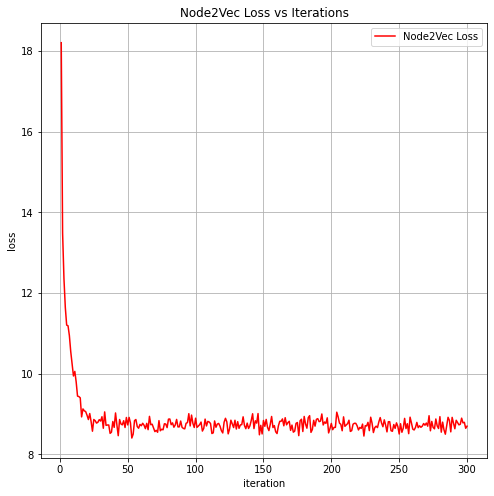

In [ ]:
x = [i for i in range(1,NUM_ITER+1)]
plt.figure(figsize=(8,8))
plt.plot(x, losses1, 'r', label='Node2Vec Loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.title("Node2Vec Loss vs Iterations")
fig.savefig('Node2VecLoss_iter.png')

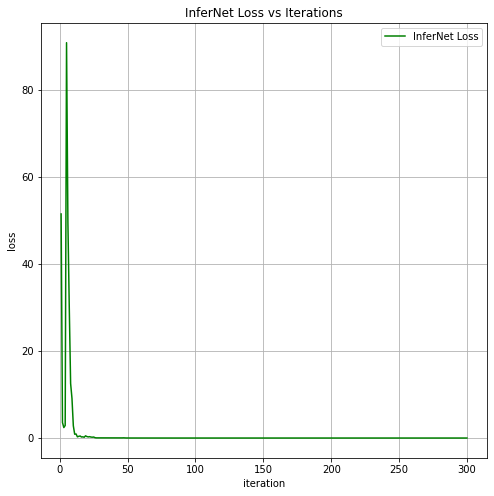

In [ ]:
x = [i for i in range(1,NUM_ITER+1)]
plt.figure(figsize=(8,8))
plt.plot(x, list(losses2), 'g', label='InferNet Loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.title("InferNet Loss vs Iterations")
fig.savefig('InferNetLoss_iter.png')

## Improve policy

In [ ]:
def improvePolicy(policy, Q, state, eps=0.1):
    q = torch.tensor([0.0, 0.0, 0.0, 0.0])
    for a in [0, 1, 2, 3]:
        if a in Q[state].keys():
            q[a] = Q[state][a]

    policy[state] = np.array([0.0, 0.0, 0.0, 0.0])
    idx = 0
    _, indices = torch.sort(q, descending=True)
    policy[state][indices[idx]] = (1.0-eps)

    while ((state+1)%8 == 0 and indices[idx]==0) or (state>=56 and state<=63 and indices[idx]==1) or (state%8 == 0 and indices[idx]==2) or (state>=0 and state<=7 and indices[idx]==3):
        policy[state][indices[idx]] = 0.0
        idx += 1
        policy[state][indices[idx]] = (1.0-eps)

    num_actions = 4.0
    if (state+1)%8 == 0:
        num_actions -= 1.0
    if state>=56 and state<=63:
        num_actions -= 1.0
    if state%8 == 0:
        num_actions -= 1.0
    if state>=0 and state<=7:
        num_actions -= 1.0

    if (state+1)%8 != 0:
        policy[state][0] += (eps/num_actions)
    if not (state>=56 and state<=63):
        policy[state][1] += (eps/num_actions)
    if state%8 != 0:
        policy[state][2] += (eps/num_actions)
    if not (state>=0 and state<=7):
        policy[state][3] += (eps/num_actions)
    
    return policy

In [ ]:
def walk_freq():
    freq = {}
    for i in range(1000):
        for start in range(NUM_NODES):
            states, a, r = sample_episode(8, start)
            for s in states:
                if s not in freq.keys():
                    freq[s] = 0
                freq[s] += 1
    matrix = np.array([[int(freq[to_node_idx(i,j)]) for i in range(8)] for j in range(8)])
    cm = sns.light_palette("green", as_cmap=True)
    x=pd.DataFrame(matrix).iloc[::-1]
    x=x.style.background_gradient(cmap=cm, axis=None)
    display(x)

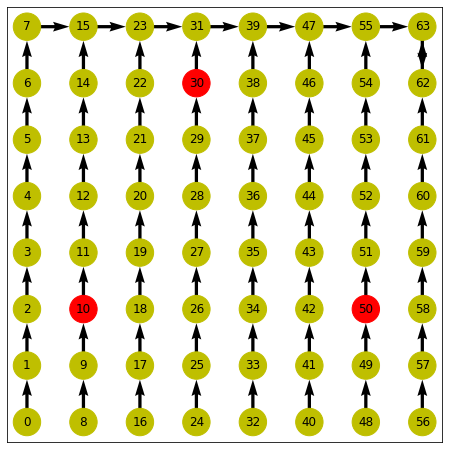

In [ ]:
plot_policy(POLICY)

In [ ]:
model1.eval()
model2.eval()
all_states = model1.forward(torch.tensor([i for i in range(NUM_NODES)])).reshape(NUM_NODES,EMBED_DIM)
imm_rewards = model2.forward(all_states).reshape(NUM_NODES,1)

In [ ]:
cum_reward = []
epsilon = 0.98
model2.eval()
NUM_ITER = 300
WALK_LEN = 5
walk_freq()

for iter in range(1,NUM_ITER+1):
    states, actions, rewards = [], [], []
    for start in range(NUM_NODES):
        s, a, r = sample_episode(WALK_LEN, start)
        states.append(s)
        actions.append(a)
        rewards.append(r)
    
    for i in range(NUM_NODES):
        G = 0.0
        for j in reversed(range(WALK_LEN-1)):
            G += float(imm_rewards[states[i][j+1]])
            s = states[i][j]
            a = actions[i][j]
            vis_prev = False
            for k in range(j):
                if states[i][k]==s and actions[i][k]==a:
                    vis_prev = True
                    break
            if vis_prev:
                continue
            
            RET[s][a].append(G)
            Q[s][a] = np.mean(RET[s][a])
            POLICY = improvePolicy(POLICY, Q, s, epsilon)

    epsilon *= 0.98
    rewards = torch.tensor(rewards).to(DEVICE)
    
    cm = float(torch.sum(rewards))/float(NUM_NODES)
    # if len(cum_reward)>0:
        # cm = (GAMMA*cm) + ((1-GAMMA)*cum_reward[-1])
    cum_reward.append(cm)

    print("iter : "+str(iter)+" |  cum_reward : "+str(cum_reward[-1]))
    if iter in [5, 10, 20, 30, 50, 75, 150, 300]:
        walk_freq()

,0,1,2,3,4,5,6,7
7,5437,7528,7260,7162,7221,7304,7712,5492
6,7668,9299,8913,8727,8857,8865,9333,7622
5,7392,9053,8402,8205,8349,8422,8770,7226
4,7270,8912,8312,8230,8297,8450,8845,7275
3,7041,8793,8323,8313,8347,8443,8912,7200
2,7222,8992,8448,8420,8421,8500,9120,7180
1,7631,9360,8934,8714,8770,9004,9600,7525
0,5393,7521,7391,7220,7105,7258,7661,5428


iter : 1 |  cum_reward : 0.265625
iter : 2 |  cum_reward : 0.28125
iter : 3 |  cum_reward : 0.265625
iter : 4 |  cum_reward : 0.203125
iter : 5 |  cum_reward : 0.375


,0,1,2,3,4,5,6,7
7,4854,7882,7211,8586,7655,7056,6650,4800
6,6574,8989,9850,12335,9928,7973,8487,7439
5,6788,8641,8868,9796,8317,7242,7587,6270
4,6332,8412,7392,8325,7430,7334,8573,6901
3,7096,9620,7473,7245,8336,9054,10438,7732
2,9582,12035,8348,6992,7335,9070,12398,8831
1,8147,9656,7622,7626,8065,8339,10489,7852
0,5824,7372,5938,6017,6801,7168,7811,5211


iter : 6 |  cum_reward : 0.40625
iter : 7 |  cum_reward : 0.3125
iter : 8 |  cum_reward : 0.328125
iter : 9 |  cum_reward : 0.4375
iter : 10 |  cum_reward : 0.40625


,0,1,2,3,4,5,6,7
7,3893,6451,7212,9445,6797,6655,5537,3793
6,5507,8753,14039,16227,11292,9674,7781,5769
5,5921,7953,9011,9365,8071,6507,6296,5133
4,5187,7509,6694,7411,7478,6608,8029,6479
3,5744,9167,8156,6300,7519,8911,12516,8095
2,7717,15049,11695,6684,7207,11806,16262,9990
1,8009,12255,9090,6706,8764,7604,9645,7431
0,5638,6673,6354,5319,6737,5486,6612,4382


iter : 11 |  cum_reward : 0.359375
iter : 12 |  cum_reward : 0.328125
iter : 13 |  cum_reward : 0.46875
iter : 14 |  cum_reward : 0.484375
iter : 15 |  cum_reward : 0.515625
iter : 16 |  cum_reward : 0.59375
iter : 17 |  cum_reward : 0.5625
iter : 18 |  cum_reward : 0.609375
iter : 19 |  cum_reward : 0.671875
iter : 20 |  cum_reward : 0.578125


,0,1,2,3,4,5,6,7
7,2890,5262,7390,11495,7450,6136,4090,2786
6,3626,6398,11172,23974,21140,11013,6660,4597
5,3464,4715,5512,9315,9361,6960,4822,3795
4,5211,7992,5177,6334,7053,5252,5915,5268
3,6462,10288,7147,4986,6980,8563,16161,7588
2,15484,23404,11239,6415,5816,14040,23529,9313
1,7969,13491,7156,4466,4732,8222,12394,6905
0,3497,4719,3725,3415,4824,6147,6959,3739


iter : 21 |  cum_reward : 0.65625
iter : 22 |  cum_reward : 0.703125
iter : 23 |  cum_reward : 0.671875
iter : 24 |  cum_reward : 0.65625
iter : 25 |  cum_reward : 0.6875
iter : 26 |  cum_reward : 0.8125
iter : 27 |  cum_reward : 0.515625
iter : 28 |  cum_reward : 0.640625
iter : 29 |  cum_reward : 0.640625
iter : 30 |  cum_reward : 0.828125


,0,1,2,3,4,5,6,7
7,2259,4428,7047,12057,5622,5575,3518,2284
6,2736,5332,12526,33078,16221,12634,7676,4081
5,2710,3440,7414,22440,7850,4279,3647,2990
4,4501,3881,3769,6329,3579,3635,5165,4723
3,8845,11132,5835,3432,3371,8947,21252,8012
2,25284,30421,8709,4901,4185,14746,30784,12398
1,8054,11150,6240,3417,3248,6356,9421,6024
0,2836,3717,4076,2652,2614,4280,5376,2859


iter : 31 |  cum_reward : 0.796875
iter : 32 |  cum_reward : 0.765625
iter : 33 |  cum_reward : 0.90625
iter : 34 |  cum_reward : 0.90625
iter : 35 |  cum_reward : 1.03125
iter : 36 |  cum_reward : 0.75
iter : 37 |  cum_reward : 0.890625
iter : 38 |  cum_reward : 0.84375
iter : 39 |  cum_reward : 0.84375
iter : 40 |  cum_reward : 0.921875
iter : 41 |  cum_reward : 0.765625
iter : 42 |  cum_reward : 0.90625
iter : 43 |  cum_reward : 0.921875
iter : 44 |  cum_reward : 0.921875
iter : 45 |  cum_reward : 1.125
iter : 46 |  cum_reward : 1.0
iter : 47 |  cum_reward : 0.828125
iter : 48 |  cum_reward : 0.953125
iter : 49 |  cum_reward : 1.0625
iter : 50 |  cum_reward : 1.015625


,0,1,2,3,4,5,6,7
7,1606,3219,5464,11167,4028,4175,2372,1647
6,1892,3956,11683,46221,17052,11753,6272,3071
5,1827,2333,6210,33082,6591,2918,2297,1939
4,3367,2622,2522,5540,2356,2129,2421,3508
3,7739,9499,4185,2325,2167,5745,7140,7747
2,35394,40365,7356,3598,2873,14866,42387,36266
1,6979,9904,4829,2141,2268,6792,6990,6682
0,2031,2523,3008,1730,1815,3196,2256,1964


iter : 51 |  cum_reward : 1.0
iter : 52 |  cum_reward : 1.09375
iter : 53 |  cum_reward : 1.03125
iter : 54 |  cum_reward : 1.125
iter : 55 |  cum_reward : 1.046875
iter : 56 |  cum_reward : 1.078125
iter : 57 |  cum_reward : 1.15625
iter : 58 |  cum_reward : 1.1875
iter : 59 |  cum_reward : 1.09375
iter : 60 |  cum_reward : 1.15625
iter : 61 |  cum_reward : 1.21875
iter : 62 |  cum_reward : 0.96875
iter : 63 |  cum_reward : 1.15625
iter : 64 |  cum_reward : 1.140625
iter : 65 |  cum_reward : 1.203125
iter : 66 |  cum_reward : 1.296875
iter : 67 |  cum_reward : 1.171875
iter : 68 |  cum_reward : 1.203125
iter : 69 |  cum_reward : 1.171875
iter : 70 |  cum_reward : 1.09375
iter : 71 |  cum_reward : 1.203125
iter : 72 |  cum_reward : 1.1875
iter : 73 |  cum_reward : 1.1875
iter : 74 |  cum_reward : 1.15625
iter : 75 |  cum_reward : 1.203125


,0,1,2,3,4,5,6,7
7,1303,2591,4410,11520,5226,3118,1608,1282
6,1394,2908,9835,58197,14016,7538,5048,2531
5,1377,1627,4802,44752,5154,1765,1587,1455
4,2681,1765,1701,4475,1650,1518,1587,2644
3,6284,7640,3160,1607,1527,4434,5270,6148
2,43842,48450,5947,2748,1985,13018,50958,45103
1,5325,8348,4001,1545,1598,5431,5279,5188
0,1462,1796,2499,1372,1359,2574,1585,1452


iter : 76 |  cum_reward : 1.234375
iter : 77 |  cum_reward : 1.15625
iter : 78 |  cum_reward : 1.265625
iter : 79 |  cum_reward : 1.09375
iter : 80 |  cum_reward : 1.234375
iter : 81 |  cum_reward : 1.28125
iter : 82 |  cum_reward : 1.28125
iter : 83 |  cum_reward : 1.328125
iter : 84 |  cum_reward : 1.3125
iter : 85 |  cum_reward : 1.375
iter : 86 |  cum_reward : 1.359375
iter : 87 |  cum_reward : 1.296875
iter : 88 |  cum_reward : 1.203125
iter : 89 |  cum_reward : 1.375
iter : 90 |  cum_reward : 1.28125
iter : 91 |  cum_reward : 1.328125
iter : 92 |  cum_reward : 1.296875
iter : 93 |  cum_reward : 1.34375
iter : 94 |  cum_reward : 1.40625
iter : 95 |  cum_reward : 1.328125
iter : 96 |  cum_reward : 1.3125
iter : 97 |  cum_reward : 1.4375
iter : 98 |  cum_reward : 1.390625
iter : 99 |  cum_reward : 1.375
iter : 100 |  cum_reward : 1.390625
iter : 101 |  cum_reward : 1.375
iter : 102 |  cum_reward : 1.3125
iter : 103 |  cum_reward : 1.453125
iter : 104 |  cum_reward : 1.25
iter : 105 

,0,1,2,3,4,5,6,7
7,1049,2105,3248,8111,3332,2189,1115,1054
6,1066,2142,6249,71486,10280,6280,4202,2107
5,1059,1094,2679,60373,2735,1135,1106,1081
4,2080,1115,1086,2637,1082,1077,1083,2109
3,3831,4813,2164,1085,1078,3233,2719,3851
2,54272,57640,3673,2114,1170,9859,60462,56146
1,2824,5794,3151,1072,1103,4217,2778,2798
0,1063,1116,2068,1054,1057,2085,1102,1062


iter : 151 |  cum_reward : 1.578125
iter : 152 |  cum_reward : 1.515625
iter : 153 |  cum_reward : 1.546875
iter : 154 |  cum_reward : 1.484375
iter : 155 |  cum_reward : 1.484375
iter : 156 |  cum_reward : 1.53125
iter : 157 |  cum_reward : 1.515625
iter : 158 |  cum_reward : 1.59375
iter : 159 |  cum_reward : 1.546875
iter : 160 |  cum_reward : 1.53125
iter : 161 |  cum_reward : 1.546875
iter : 162 |  cum_reward : 1.515625
iter : 163 |  cum_reward : 1.546875
iter : 164 |  cum_reward : 1.5625
iter : 165 |  cum_reward : 1.5625
iter : 166 |  cum_reward : 1.546875
iter : 167 |  cum_reward : 1.5625
iter : 168 |  cum_reward : 1.53125
iter : 169 |  cum_reward : 1.484375
iter : 170 |  cum_reward : 1.484375
iter : 171 |  cum_reward : 1.546875
iter : 172 |  cum_reward : 1.5625
iter : 173 |  cum_reward : 1.53125
iter : 174 |  cum_reward : 1.53125
iter : 175 |  cum_reward : 1.546875
iter : 176 |  cum_reward : 1.46875
iter : 177 |  cum_reward : 1.53125
iter : 178 |  cum_reward : 1.578125
iter : 1

,0,1,2,3,4,5,6,7
7,1004,2007,3012,7039,3011,2004,1002,1001
6,1001,2004,5050,74850,9081,6019,4014,2004
5,1002,1004,2028,64790,2035,1006,1005,1004
4,2007,1006,1002,2031,1001,1002,1004,2001
3,3044,4031,2007,1003,1003,3010,2038,3039
2,56885,59880,3029,2004,1007,9043,62901,58859
1,2040,5031,3004,1004,1002,4000,2051,2039
0,1000,1005,2004,1002,1000,2000,1002,1002


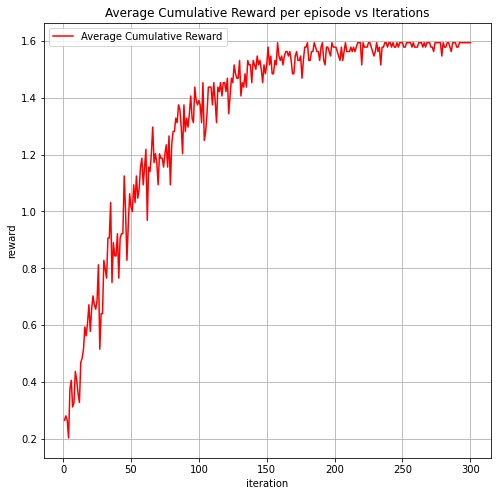

In [ ]:
x = [i for i in range(1,len(cum_reward)+1)]
plt.figure(figsize=(8,8))
plt.plot(x, cum_reward, 'r', label='Average Cumulative Reward')
plt.xlabel('iteration')
plt.ylabel('reward')
plt.grid()
plt.legend()
plt.title("Average Cumulative Reward per episode vs Iterations")
fig.savefig('CumReward_iter.png')

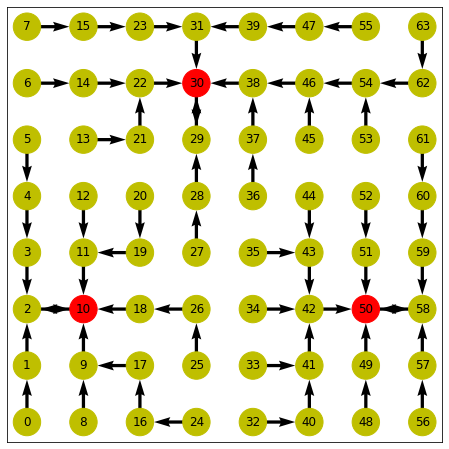

In [ ]:
plot_policy(POLICY)